In [43]:
import os
import json
import random
import warnings

import numpy as np

from tqdm import tqdm
import geopandas as gpd
from shapely import buffer
from shapely.geometry import Point
from shapely.ops import transform
import asf_search as asf
# pip/conda/mamba install asf_search[extras]


import pyproj
import pystac
from pystac.utils import str_to_datetime
import rasterio
from rasterio.env import Env
from rio_stac.stac import PROJECTION_EXT_VERSION, RASTER_EXT_VERSION, EO_EXT_VERSION
from rio_stac.stac import (
    get_dataset_geom,
    get_projection_info,
    get_raster_info,
    bbox_to_geom,
)

from odc.stac import load
from odc.geo.geobox import GeoBox

from shapely.geometry import Point, shape as s_shape

In [44]:
def palsar_dn_to_db(data, offset=-83.):
    """
    Convert Digital Number to dB

    Parameters
    ----------
    data : xarray.DataArray
        Digital Number data
    scale : float, default 1
        Scale factor
    offset : float, default 0
        Offset

    Returns
    -------
    data : xarray.DataArray
        dB data
    """
    return 10 * np.log10(data.astype('int32')**2) + offset


def items_to_dataframe(items, to_crs=None):
    """
    Convert a list of STAC items to a GeoDataFrame

    Parameters
    ----------
    items : list
        List of STAC items
    crs : str, default 'EPSG:4326' as the stac items are in WGS84
        CRS of the GeoDataFrame

    Returns
    -------
    gdf : GeoDataFrame
        GeoDataFrame with the STAC items
    """
    d = []
    asset_id = []
    geometry = []
    assets = []
    for i in items:
        d.append(i.properties)
        asset_id.append(i.id)
        assets.append(list(i.assets.keys()))
        geometry.append(s_shape(i.geometry))
    gdf = gpd.GeoDataFrame(d, geometry=geometry, crs="EPSG:4326")
    gdf["asset_id"] = asset_id
    gdf["assets"] = assets
    gdf["asset_items"] = items
    if to_crs is not None:
        gdf = gdf.to_crs(f"EPSG:{to_crs}")
    return gdf

def create_alos_palsar_stac_item(folder):
    files = os.listdir(folder)
    asset_files = [[f.split('-')[0], f] for f in files if f.endswith(".tif")]
    properties = {}
    try:
        with open(os.path.join(folder, "summary.txt"), "r") as file:
            meta = {
                m[0]: m[1]
                for m in [
                    m.replace("\n", "").replace('"', '').split("=")
                    for m in file.readlines()
                ]
            }
        names = ['platform', 'instrument', 'ALPS:sceneID', 'ALPS:pixelSpacing', 
                 'ALPS:DEM', 'ALPS:geoid', 'ALPS:processingLevel', 'ALPS:offNadirAngle']
        specs = ['Lbi_Satellite', 'Lbi_Sensor', 'Scs_SceneID', 'Pds_PixelSpacing', 
                 'Pds_DigitalElevationModel', 'Pds_GeoidModel', 'Lbi_ProcessLevel', 'Img_OffNadirAngle']
        for i in zip(names, specs):
            properties[i[0]] = meta[i[1]]
        input_datetime = str_to_datetime(meta['Img_SceneCenterDateTime'])
    except:
        raise ValueError("Could not read summary.txt file")

    try:
        with open(os.path.join(folder, "properties.txt"), "r") as file:
            text_dict = file.read()
            prop ={
                m[0]: m[1]
                for m in [
                    m.replace("\n", "").replace('"', '').split("=")
                    for m in text_dict.split('\n')
                ]
            }
        names = ['start_datetime', 'end_datetime', 'ALPS:beamMode', 'ALPS:flightDirection', 
                 'ALPS:orbit', 'ALPS:pathNumber', 'ALPS:frameNumber', 'ALPS:polarization']
        specs = ['startTime', 'stopTime', 'beamModeType', 'flightDirection', 
                 'orbit', 'pathNumber', 'frameNumber', 'polarization']
        for i in zip(names, specs):
            properties[i[0]] = prop[i[1]]
        collection_url = prop["url"]
    except:
        collection_url = None
        warn = f"Could not read properties.txt file, some metadata is missing for item {properties['ALPS:sceneID']}"
        warnings.warn(warn)
    
    assets = [{
        "name": name,
        "path": os.path.join(folder, filename),
        "href": None,
        "role": "data",
    } for name, filename in asset_files]

    media_type = pystac.MediaType.TIFF  # we could also use rio_stac.stac.get_media_type

    collection = "ASF ALOS PALSAR"
    

    extensions = [
        f"https://stac-extensions.github.io/projection/{PROJECTION_EXT_VERSION}/schema.json",
        f"https://stac-extensions.github.io/raster/{RASTER_EXT_VERSION}/schema.json",
        f"https://stac-extensions.github.io/eo/{EO_EXT_VERSION}/schema.json",
    ]

    bboxes = []

    pystac_assets = []

    crs = []

    for asset in assets:
        with Env(GTIFF_SRS_SOURCE='EPSG'):  # CRS definition in the GTiff differs from EPSG: 
        # WARNING:rasterio._env:CPLE_AppDefined in The definition of projected CRS EPSG:32653 got from GeoTIFF 
        # keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. 
        # Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), 
        # or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.

        # choosing between the two options gives different values in the image position after the 9th decimal place (lat lon)
            with rasterio.open(asset["path"]) as src_dst:
                # Get BBOX and Footprint
                dataset_geom = get_dataset_geom(src_dst, densify_pts=0, precision=-1)
                bboxes.append(dataset_geom["bbox"])

                proj_info = {
                    f"proj:{name}": value
                    for name, value in get_projection_info(src_dst).items() if name in ['bbox', 'shape', 'transform']
                }
                crs.append(get_projection_info(src_dst)['projjson']['id']['code'])

                raster_info = {
                    "raster:bands": get_raster_info(src_dst, max_size=1024)
                }

                pystac_assets.append(
                    (
                        asset["name"],
                        pystac.Asset(
                            href=asset["href"] or src_dst.name,
                            media_type=media_type,
                            extra_fields={
                                **proj_info,
                                **raster_info,
                            },
                            roles=asset["role"],
                        ),
                    )
                )

    minx, miny, maxx, maxy = zip(*bboxes)
    bbox = [min(minx), min(miny), max(maxx), max(maxy)]

    if len(set(crs)) > 1:
        raise ValueError("Multiple CRS found in the assets")

    properties['proj:epsg'] = crs[0]

    # item
    item = pystac.Item(
        id=properties['ALPS:sceneID'],
        geometry=bbox_to_geom(bbox),
        bbox=bbox,
        collection=collection,
        stac_extensions=extensions,
        datetime=input_datetime,
        properties=properties,
    )

    # if we add a collection we MUST add a link
    if collection:
        item.add_link(
            pystac.Link(
                pystac.RelType.COLLECTION,
                collection_url or collection,
                media_type=pystac.MediaType.JSON,
            )
        )
    for key, asset in pystac_assets:
        item.add_asset(key=key, asset=asset)
    return item


def generate_random_points(num_points):
    # Function to generate random points on the globe
    points = []
    for _ in range(num_points):
        lat = random.uniform(-90, 90)
        lon = random.uniform(-180, 180)
        points.append(Point(lon, lat))
    return points

In [45]:
points = [Point(138.4307, 38.04381)]  # generate_random_points(10)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")


In [46]:

# Buffer the points by 100 meters
gdf_buffered = gdf.to_crs(epsg=3857).buffer(100).to_crs(epsg=4326)

# Search for ALOS data intersecting with the buffered points and within the specified time range
opts = {
    "platform": asf.PLATFORM.ALOS,
    "instrument": asf.INSTRUMENT.PALSAR,
    "beamMode": ["FBD", "PLR"],
    "processingLevel": "L2.2",
    "start": "2006-01-01T00:00:00Z",
    "end": "2012-02-01T23:59:59Z",
}

# Perform the search
results = []
for i in gdf_buffered.to_wkt():
    results.append(asf.geo_search(intersectsWith=i, **opts))

In [47]:
import pystac.item

path = "/Net/Groups/BGI/work_4/scratch/mzehner/temp_alos"
# Download the results
# Create an ASF session use your username and password from https://urs.earthdata.nasa.gov/
session = asf.ASFSession().auth_with_creds("zehma", "iZ5CJRNRQLY7Bee")


for idx, i in enumerate(results):
    print(f'Point {idx+1} of {len(results)}')
    for r in tqdm(i, desc='Downloading scenes found'):
        if os.path.isfile(os.path.join(*[path, r.properties['sceneName'], "summary.txt"])):
                continue
        with r.remotezip(session=session) as remotezip:
            file_paths = [
                file.filename
                for file in remotezip.filelist
                if file.filename.endswith(".tif")
            ]
            folder = file_paths[0].split("-")[1]
            out = os.path.join(path, folder)
            os.makedirs(out, exist_ok=True)
            for file_path in file_paths:
                remotezip.extract(file_path, path=out)
            remotezip.extract("summary.txt", path=out)

            with open(os.path.join(out, "properties.txt"), "w") as f:
                (f.write(str(r.properties).replace("'", "").replace(": ", "=")
                        .replace(', ', '\n').replace('{', '').replace('}', '')
                        .replace('[', '').replace(']', '')))

items = []
alos_folders = [os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
for fi in alos_folders:
    if not os.path.isfile(os.path.join(fi, "summary.txt")):
        continue
    if os.path.isfile(os.path.join(fi, f"{fi.split('/')[-1]}.json")):
       item = pystac.Item.from_dict(json.load(open(os.path.join(fi, f"{fi.split('/')[-1]}.json"))))
    else:
        item = create_alos_palsar_stac_item(fi)
        item_path = os.path.join(fi, f"{item.id}.json")
        
        with open(item_path, 'w') as f:
            json.dump(item.to_dict(), f, indent=4)

    items.append(item)

Point 1 of 1


In [48]:
# loading this data could be done with the following options:
requested_bands = ["HH", "HV", "INC", "MASK"]
chunking = {"x": 512, "y": 512, "time": -1}

gpd_items = items_to_dataframe(items)

project1 = pyproj.Transformer.from_proj(
        pyproj.Proj(init=f'epsg:4326'), # source coordinate system
        pyproj.Proj(init='epsg:3857')) # destination coordinate system

gpd_items["geometry"] = gpd_items["geometry"].apply(lambda x: transform(project1.transform, x))

In [49]:

for i, point in enumerate(gdf.itertuples()):

    print(f"Processing point {i}, {point}")

    # g1 is a shapley Polygon
    lat = point.geometry.y
    lon = point.geometry.x
    point_buffer_metric = buffer(transform(project1.transform, point.geometry), 5000)
    
    items_local = gpd_items[gpd_items.intersects(point_buffer_metric)]

    #if GEOKEYS

    for e in items:
        e.properties["proj:epsg"]

    epsg = items_local["proj:epsg"].iloc[0]

    project2 = pyproj.Transformer.from_proj(
        pyproj.Proj(init='epsg:3857'), # source coordinate system
        pyproj.Proj(init=f'epsg:{epsg}')) # destination coordinate system
    point_buffer_local_crs = transform(project2.transform, point_buffer_metric)

    geobox = GeoBox.from_bbox(point_buffer_local_crs.bounds, crs=f"epsg:{epsg}", resolution=25)



    dc = load(
        items_local['asset_items'],
        bands=requested_bands,
        chunks=chunking,
        geobox=geobox,
        dtype="uint16",
        resampling="bilinear",
        groupby="solar_day",
    )

    # add custom metadata as coordinates to the dataset
    items_local = items_local.groupby("datetime").first().sort_values("datetime")

    extra = ['asset_id', 'ALPS:offNadirAngle', 'ALPS:beamMode', 'ALPS:flightDirection', 'ALPS:pathNumber', 'ALPS:frameNumber']

    for e in extra:
        dc[e] = items_local[e].values

    with Env(GTIFF_SRS_SOURCE='EPSG'):
        dc.to_zarr(f"alos_palsar_{i}_lat_{lat:.4f}_lon_{lon:.4f}.zarr", mode="w", 
                   write_empty_chunks=False)

Processing point 0, Pandas(Index=0, geometry=<POINT (138.431 38.044)>)


In [50]:
dc

<xarray.Dataset> Size: 13MB
Dimensions:               (y: 315, x: 317, time: 16, asset_id: 19,
                           ALPS:offNadirAngle: 19, ALPS:beamMode: 19,
                           ALPS:flightDirection: 19, ALPS:pathNumber: 19,
                           ALPS:frameNumber: 19)
Coordinates:
  * y                     (y) float64 3kB 4.218e+06 4.218e+06 ... 4.21e+06
  * x                     (x) float64 3kB 2.706e+05 2.706e+05 ... 2.785e+05
    spatial_ref           int32 4B 32654
  * time                  (time) datetime64[ns] 128B 2006-07-05T13:01:48.2210...
  * asset_id              (asset_id) object 152B 'ALPSRP023700750' ... 'ALPSR...
  * ALPS:offNadirAngle    (ALPS:offNadirAngle) object 152B '23.1' ... '34.3'
  * ALPS:beamMode         (ALPS:beamMode) object 152B 'PLR' 'PLR' ... 'FBD'
  * ALPS:flightDirection  (ALPS:flightDirection) object 152B 'ASCENDING' ... ...
  * ALPS:pathNumber       (ALPS:pathNumber) object 152B '403' '403' ... '407'
  * ALPS:frameNumber      (ALPS:frameNumber) object 152B '750' '760' ... '750'
Data variables:
    HH                    (time, y, x) uint16 3MB dask.array<chunksize=(16, 315, 317), meta=np.ndarray>
    HV                    (time, y, x) uint16 3MB dask.array<chunksize=(16, 315, 317), meta=np.ndarray>
    INC                   (time, y, x) uint16 3MB dask.array<chunksize=(16, 315, 317), meta=np.ndarray>
    MASK                  (time, y, x) uint16 3MB dask.array<chunksize=(16, 315, 317), meta=np.ndarray>

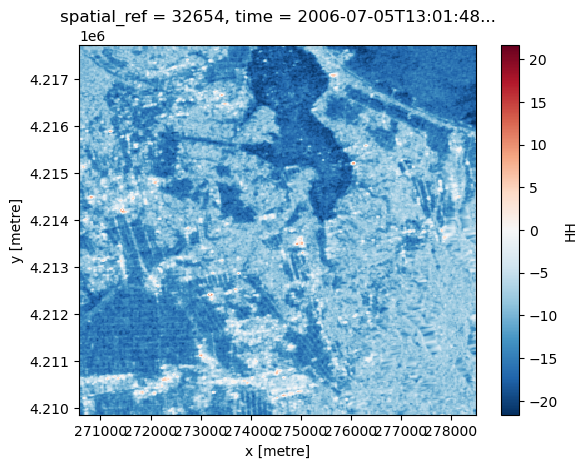

In [51]:
palsar_dn_to_db(dc.HH.isel(time=0)).plot()